# Tokenize and save data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../..')
from src.encode_data import *
# from src.fastai_data import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [3]:
import pandas as pd
import numpy as np

In [4]:
from fastai.text import *

In [5]:
from fastai.text import data

## Preparing the data

In [8]:
# version = 'v13'
version = 'v10'
data_path = Path('data/midi')
version_path = data_path/version
source_dir = 'midi_encode'
# source_dir = 'piano_duet'
out_path = version_path/source_dir
csv_path = out_path/f'{source_dir}.csv'
version_path.ls()

[PosixPath('data/midi/v10/midi_sources'),
 PosixPath('data/midi/v10/midi_encode'),
 PosixPath('data/midi/v10/metadata')]

In [9]:
csv = pd.read_csv(csv_path)
csv = csv.loc[csv['numpy'].notna()];

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
def get_files(csv, limit=1000):
    files = csv['numpy']
    flist = [Path(version_path/f) for f in files.values[:1000]]
    flist = [f for f in flist if f.exists()]
    return flist

In [11]:
version_path

PosixPath('data/midi/v10')

### Create All Dataset

In [12]:
csv.head()

,ht_bpm,md5,numpy,ht_time_signature,midi_title,source,artist,ht_offset,section,song_url,mxl,ht_key,parts,title,genres,midi,ht_mode
0,128.0,bf1f29e5ff84e3e93e37fb873bfb590e,midi_encode/hooktheory/pianoroll/w/wayne-sharp...,4.0,yu-gi-oh3,hooktheory,wayne-sharpe,0.0,chorus,https://www.hooktheory.com/theorytab/view/wayn...,NaN,C,"intro,chorus",yu-gi-oh-theme-song,NaN,midi_sources/hooktheory/pianoroll/w/wayne-shar...,1.0
1,85.0,055f80ad67f64edb14a85ca8fbfe8c29,midi_encode/hooktheory/pianoroll/w/wayne-sharp...,3.0,yu-gi-oh,hooktheory,wayne-sharpe,0.0,intro,https://www.hooktheory.com/theorytab/view/wayn...,NaN,C,"intro,chorus",yu-gi-oh-theme-song,NaN,midi_sources/hooktheory/pianoroll/w/wayne-shar...,1.0
2,96.0,197f96f5d181f6ce1e2c5ab04ac1ff87,midi_encode/hooktheory/pianoroll/w/what-a-day/...,4.0,kiefer,hooktheory,what-a-day,-5.0,chorus,https://www.hooktheory.com/theorytab/view/what...,NaN,D,chorus,kiefer,Jazz,midi_sources/hooktheory/pianoroll/w/what-a-day...,6.0
3,152.0,9e7ce13a35f1314423a9a6d5a5287a4a,midi_encode/hooktheory/pianoroll/w/whiteflame/...,4.0,senbonzakura - pre-Pre-Chorus,hooktheory,whiteflame,-5.0,pre-chorus,https://www.hooktheory.com/theorytab/view/whit...,NaN,D,"verse,pre-chorus,chorus",senbonzakura,"J-Pop,Pop",midi_sources/hooktheory/pianoroll/w/whiteflame...,6.0
4,152.0,d5aaf79d0989222f1362f9f46c540a27,midi_encode/hooktheory/pianoroll/w/whiteflame/...,4.0,Senbonzakura,hooktheory,whiteflame,-5.0,verse,https://www.hooktheory.com/theorytab/view/whit...,NaN,D,"verse,pre-chorus,chorus",senbonzakura,"J-Pop,Pop",midi_sources/hooktheory/pianoroll/w/whiteflame...,6.0


In [13]:
csv.shape

(174994, 17)

In [13]:
# all_files = get_files(csv)
# all_data = create_databunch(all_files, cache_name='tmp/all', load_cached=True)

### fastai_data

In [235]:
BOS = 'bos'
PAD = 'pad'
EOS = 'eos'
CLS = 'cls'
MASK = 'mask'
CSEQ = 'cseq'
MSEQ = 'mseq'
FSEQ = 'fseq'

SPECIAL_TOKS = [BOS, PAD, EOS, CLS, MASK, CSEQ, MSEQ, FSEQ]

SEP = 'n0'
NOFF = 'n0'
DOFF = 'd0'

# single stream instead of note,dur
def to_single_stream(t, vocab):
    t = t.copy()
    t[:, 0] = t[:, 0] + vocab.stoi[NOFF]
    t[:, 1] = t[:, 1] + vocab.stoi[DOFF]
    stream = t.reshape(-1)
    bos_seq = np.array([vocab.stoi[BOS], vocab.stoi[PAD]])
    return  np.contatenate([bos_seq, t.reshape(-1)])

def to_double_stream(t, vocab):
    t = t.copy().reshape(-1, 2)
    t[:, 0] = t[:, 0] - vocab.stoi[NOFF]
    t[:, 1] = t[:, 1] - vocab.stoi[DOFF]
    return t

class Vocab():
    "Contain the correspondence between numbers and tokens and numericalize."
    def __init__(self, itos:Collection[str]):
        self.itos = itos
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return [self.stoi[w] for w in t]

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        return sep.join([self.itos[i] for i in nums]) if sep is not None else [self.itos[i] for i in nums]

    def __getstate__(self):
        return {'itos':self.itos}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

    def save(self, path):
        "Save `self.itos` in `path`"
        pickle.dump(self.itos, open(path, 'wb'))

    @classmethod
    def create(cls) -> 'Vocab':
        "Create a vocabulary from a set of `tokens`."
        note_range = 128
        duration_range = 128
        itos = SPECIAL_TOKS + [f'n{i}' for i in range(note_range)] + [f'd{i}' for i in range(duration_range)]
        return cls(itos)
    
    @classmethod
    def load(cls, path):
        "Load the `Vocab` contained in `path`"
        itos = pickle.load(open(path, 'rb'))
        return cls(itos)


In [233]:
vocab = Vocab.create()

In [23]:
v.itos

['bos',
 'pad',
 'eos',
 'cls',
 'cseq',
 'mseq',
 'fseq',
 'sep',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14',
 'n15',
 'n16',
 'n17',
 'n18',
 'n19',
 'n20',
 'n21',
 'n22',
 'n23',
 'n24',
 'n25',
 'n26',
 'n27',
 'n28',
 'n29',
 'n30',
 'n31',
 'n32',
 'n33',
 'n34',
 'n35',
 'n36',
 'n37',
 'n38',
 'n39',
 'n40',
 'n41',
 'n42',
 'n43',
 'n44',
 'n45',
 'n46',
 'n47',
 'n48',
 'n49',
 'n50',
 'n51',
 'n52',
 'n53',
 'n54',
 'n55',
 'n56',
 'n57',
 'n58',
 'n59',
 'n60',
 'n61',
 'n62',
 'n63',
 'n64',
 'n65',
 'n66',
 'n67',
 'n68',
 'n69',
 'n70',
 'n71',
 'n72',
 'n73',
 'n74',
 'n75',
 'n76',
 'n77',
 'n78',
 'n79',
 'n80',
 'n81',
 'n82',
 'n83',
 'n84',
 'n85',
 'n86',
 'n87',
 'n88',
 'n89',
 'n90',
 'n91',
 'n92',
 'n93',
 'n94',
 'n95',
 'n96',
 'n97',
 'n98',
 'n99',
 'n100',
 'n101',
 'n102',
 'n103',
 'n104',
 'n105',
 'n106',
 'n107',
 'n108',
 'n109',
 'n110',
 'n111',
 'n112',
 'n113',
 'n114',
 'n115',
 'n116

In [16]:
"Fast parallel databunch creation and special npencoding DataBunch"
from fastai.text import *
from numbers import Integral
from src.encode_data import npenc2seq

## For npenc dataset

def rand_transpose(t, enc_offset, rand_range=(0,24), p=0.5):
    t = t.copy()
    notes = t[...,0]
    if np.random.rand() < p:
        notes[notes >= enc_offset] += np.random.randint(*rand_range)-rand_range[1]//2
    return t

def rand_category(t, pad_idx, bos_idx, p=0.5):
    t = t.copy()
    if np.random.rand() < p:
        assert(t[0,0] == bos_idx)
        t[0,1] = pad_idx
    return t

# single stream instead of note,dur
def to_single_stream(t, offset=130):
    t = t.copy()
    t[:, 1] = t[:, 1] + offset
    return t.reshape(-1)

def to_double_stream(t, offset=130):
    t = t.copy().reshape(-1, 2)
    t[:, 1] = t[:, 1] - offset
    return t

def create_vocab_sizes(cache_path):
    max_vocab_file = cache_path/'max_vocab.npy'
    if max_vocab_file.exists(): return np.load(max_vocab_file).tolist()
    max_vocab = np.array(130, 150)
    np.save(max_vocab_file, max_vocab)
    return max_vocab.tolist()

class OpenNPFileProcessor(PreProcessor):
    "`PreProcessor` that opens the filenames and read the texts."
    def process_one(self,item):
        return np.load(item, allow_pickle=True) if isinstance(item, Path) else item
    
class LMNPDataBunch(DataBunch):
    "Create a `TextDataBunch` suitable for training a language model."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', no_check:bool=False, bs=64, val_bs:int=None, 
               num_workers:int=0, device:torch.device=None, collate_fn:Callable=data_collate, 
               dl_tfms:Optional[Collection[Callable]]=None, bptt:int=70, backwards:bool=False, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` in `path` from the `datasets` for language modelling."
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        datasets = [LMNPPreloader(ds, shuffle=(i==0), bs=(bs if i==0 else val_bs), bptt=bptt, backwards=backwards) 
                    for i,ds in enumerate(datasets)]
        val_bs = bs
        dls = [DataLoader(d, b, shuffle=False) for d,b in zip(datasets, (bs,val_bs,val_bs,val_bs)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)
    
    @classmethod    
    def from_ids(cls, path:PathOrStr, train_ids:Collection[Collection[int]], valid_ids:Collection[Collection[int]],
                 test_ids:Collection[Collection[int]]=None, train_lbls:Collection[Union[int,float]]=None,
                 valid_lbls:Collection[Union[int,float]]=None, classes:Collection[Any]=None,
                 processor:PreProcessor=None,
                 train_tfms=None, valid_tfms=None,
                 **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from ids, labels and a `vocab`. `kwargs` are passed to the dataloader creation."
        src = ItemLists(path, LMNPItemList(train_ids, path=path, processor=[], tfms=train_tfms),
                        LMNPItemList(valid_ids, path=path, processor=[], tfms=valid_tfms))
        src = src.label_const(label_cls=LMLabelList)
        if not is1d(train_lbls): src.train.y.one_hot,src.valid.y.one_hot = True,True
        return src.databunch(**kwargs)
    
    def save(self, cache_name:PathOrStr='tmp'):
        "Save the `DataBunch` in `self.path/cache_name` folder."
        os.makedirs(self.path/cache_name, exist_ok=True)
        cache_path = self.path/cache_name
        np.save(cache_path/f'train_ids.npy', self.train_ds.x.items)
        np.save(cache_path/f'train_lbl.npy', self.train_ds.y.items)
        np.save(cache_path/f'valid_ids.npy', self.valid_ds.x.items)
        np.save(cache_path/f'valid_lbl.npy', self.valid_ds.y.items)
        if self.test_dl is not None: np.save(cache_path/f'test_ids.npy', self.test_ds.x.items)
        if hasattr(self.train_ds, 'classes'): save_texts(cache_path/'classes.txt', self.train_ds.classes)

    @classmethod
    def load(cls, path:PathOrStr, cache_name:PathOrStr='tmp', processor:PreProcessor=None, **kwargs):
        "Load a `TextDataBunch` from `path/cache_name`. `kwargs` are passed to the dataloader creation."
        cache_path = Path(path)/cache_name
        train_ids,train_lbls = np.load(cache_path/f'train_ids.npy', allow_pickle=True), np.load(cache_path/f'train_lbl.npy', allow_pickle=True)
        valid_ids,valid_lbls = np.load(cache_path/f'valid_ids.npy', allow_pickle=True), np.load(cache_path/f'valid_lbl.npy', allow_pickle=True)
        test_ids = np.load(cache_path/f'test_ids.npy', allow_pickle=True) if os.path.isfile(cache_path/f'test_ids.npy') else None
        classes = loadtxt_str(cache_path/'classes.txt') if os.path.isfile(cache_path/'classes.txt') else None
        return cls.from_ids(path, train_ids, valid_ids, test_ids, train_lbls, valid_lbls, classes, processor, **kwargs)

class LMNPItemList(ItemList):
    _bunch = LMNPDataBunch
    
    def __init__(self, *args, tfms=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.tfms = tfms or []
        
    def get(self, i)->Any:
        item = self.items[i]
        if self.tfms is None: return item
        for tfm in self.tfms: item = tfm(item)
        return item

class LMNPPreloader(Callback):
    "Transforms the tokens in `dataset` to a stream of contiguous batches for language modelling."
    
    class CircularIndex():
        "Handles shuffle, direction of indexing, wraps around to head tail in the ragged array as needed"
        def __init__(self, length:int, forward:bool): self.idx, self.forward = np.arange(length), forward
        def __getitem__(self, i): 
            return self.idx[ i%len(self.idx) if self.forward else len(self.idx)-1-i%len(self.idx)]
        def __len__(self) -> int: return len(self.idx)
        def shuffle(self): np.random.shuffle(self.idx)

    def __init__(self, dataset:LabelList, lengths:Collection[int]=None, bs:int=32, bptt:int=70, backwards:bool=False, 
                 shuffle:bool=False, y_offset:int=1):
        self.dataset,self.bs,self.bptt,self.shuffle,self.backwards,self.lengths = dataset,bs,bptt,shuffle,backwards,lengths
        self.bs *= num_distrib() or 1
        self.totalToks,self.ite_len,self.idx = int(0),None,None
        self.y_offset = 1
        self.allocate_buffers() # needed for valid_dl on distributed training - otherwise doesn't get initialized on first epoch

    def __len__(self): 
        if self.ite_len is None:
            if self.lengths is None: self.lengths = np.array([len(item) for item in self.dataset.x])
            self.totalToks = self.lengths.sum()
            self.ite_len   = self.bs*int( math.ceil( self.totalToks/(self.bptt*self.bs) )) if self.item is None else 1
        return self.ite_len

    def __getattr__(self,k:str)->Any: return getattr(self.dataset, k)
   
    def allocate_buffers(self):
        "Create the ragged array that will be filled when we ask for items."
        if self.ite_len is None: len(self)
        self.idx   = LMNPPreloader.CircularIndex(len(self.dataset.x), not self.backwards)
        self.batch = np.zeros((self.bs, self.bptt+self.y_offset) + self.dataset.x[0].shape[1:], dtype=np.int64)
        self.batch_x, self.batch_y = self.batch[:,0:self.bptt], self.batch[:,self.y_offset:self.bptt+self.y_offset] 
        #ro: index of the text we're at inside our datasets for the various batches
        self.ro    = np.zeros(self.bs, dtype=np.int64)
        #ri: index of the token we're at inside our current text for the various batches
        self.ri    = np.zeros(self.bs, dtype=np.int)

    def on_epoch_begin(self, **kwargs):
        if self.idx is None: self.allocate_buffers()
        elif self.shuffle:   self.idx.shuffle()
        self.idx.forward = not self.backwards 

        step = self.totalToks / self.bs
        ln_rag, countTokens, i_rag = 0, 0, -1
        for i in range(0,self.bs):
            #Compute the initial values for ro and ri 
            while ln_rag + countTokens <= int(step * i):
                countTokens += ln_rag
                i_rag       += 1
                ln_rag       = self.lengths[self.idx[i_rag]]
            self.ro[i] = i_rag
            self.ri[i] = ( ln_rag - int(step * i - countTokens) ) if self.backwards else int(step * i - countTokens)
        
    #Training dl gets on_epoch_begin called, val_dl, on_epoch_end
    def on_epoch_end(self, **kwargs): self.on_epoch_begin()

    def __getitem__(self, k:int):
        j = k % self.bs
        if j==0:
            if self.item is not None: return self.dataset[0]
            if self.idx is None: self.on_epoch_begin()
        self.ro[j],self.ri[j] = self.fill_row(not self.backwards, self.dataset.x, self.idx, self.batch[j], 
                                              self.ro[j], self.ri[j], overlap=1, lengths=self.lengths)
        return self.batch_x[j], self.batch_y[j]

    def fill_row(self, forward, items, idx, row, ro, ri, overlap, lengths):
        "Fill the row with tokens from the ragged array. --OBS-- overlap != 1 has not been implemented"
        ibuf = n = 0 
        ro  -= 1
        while ibuf < row.shape[0]:  
            ro   += 1 
            ix    = idx[ro]
            rag   = items[ix]
            if forward:
                ri = 0 if ibuf else ri
                n  = min(lengths[ix] - ri, row.shape[0] - ibuf)
                row[ibuf:ibuf+n] = rag[ri:ri+n]
            else:    
                ri = lengths[ix] if ibuf else ri
                n  = min(ri, row.size - ibuf) 
                row[ibuf:ibuf+n] = rag[ri-n:ri][::-1]
            ibuf += n
        return ro, ri + ((n-overlap) if forward else -(n-overlap))


In [27]:
512 / 3

170.66666666666666

In [ ]:
512 / 2 -> 256
512 / 3 -> 170
512 / 4 -> 128


In [42]:
x = torch.arange(100).reshape(5,20); x

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
         58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
         78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
         98, 99]])

In [44]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [142]:
s = 4
bs,bptt = 8,512
p1 = bptt // s

bs_shift = (np.random.choice(bs-1,s, replace=False)+1).tolist()
row_shift = [int(p1 + random.randint(-p1, p1)//s) for i in range(s)]

accum = 0
ranges = []
for i in range(s):
    end = accum + row_shift[i] if i < (s-1) else bptt
    ranges.append((i, bs_shift[i], accum, end))
    accum = end
# out = [(i, (p1 + random.randint(-p1, p1)//2)) for i in range(1, s)]; out
# swap = torch.zeros_like(x)
# for i, idx in 
ranges

[(0, 3, 0, 98), (1, 7, 98, 247), (2, 2, 247, 394), (3, 5, 394, 512)]

In [137]:
shifts = np.random.choice(bs-1,s, replace=False)+1

In [116]:
x = torch.arange(60).reshape(4,15); x

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])

In [132]:
torch.roll(x, shifts=2, dims=0)

tensor([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [128]:
x[2:5]

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])

In [216]:
def next_sentence_ranges(x, y, max_cls=4):
    s = random.randint(1, max_cls)
    bs,bptt = x.shape
    
    psz = bptt // s

    bs_shift = [0]+(np.random.choice(bs-1,s, replace=False)+1).tolist()
    row_shift = [int(psz + random.randint(-psz, psz)//s) for i in range(s)]
    
    accum = 0
    ranges = []
    for i in range(s):
        end = accum + row_shift[i] if i < (s-1) else bptt
        ranges.append((i, bs_shift[i], accum, end))
        accum = end
    return ranges

def next_sentence_tfm(x, y, max_cls=4):
    x_new = x.clone()
    y_new = y.clone()
    z = torch.zeros_like(x)
    ranges = next_sentence_ranges(x, y, max_cls)
    for i,shift,s,e in ranges:
        if i == 0: continue
        x_new[:, s:e] = torch.roll(x, shifts=shift, dims=0)[:, s:e]
        y_new[:, s:e] = torch.roll(y, shifts=shift, dims=0)[:, s:e]
        z[:, s:e] = i
    return x_new, y_new, z

In [217]:
x = torch.arange(512).reshape(8,64)

In [228]:
next_sentence_ranges(x, x.clone())

[(0, 0, 0, 18), (1, 1, 18, 35), (2, 2, 35, 53), (3, 3, 53, 64)]

In [232]:
next_sentence_tfm(x, x.clone())

(tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
          284, 285, 286, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
          170, 171, 172, 173, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
          120, 121, 122, 123, 124, 125, 126, 127],
         [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
          348, 349, 350, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
          234, 235, 236, 237, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
          184, 185, 186, 187, 188, 189, 190, 191],
         [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
          398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
          412, 413, 414, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
          298, 299

In [158]:
%debug

> /Users/andrewshaw/Projects/ML/music/midi_generator/notebooks/data_formatting/mtrand.pyx(1168)mtrand.RandomState.choice()

ipdb> !!s
*** SyntaxError: invalid syntax
ipdb> !s
*** NameError: name 's' is not defined
ipdb> !bs
*** NameError: name 'bs' is not defined
ipdb> bs
*** NameError: name 'bs' is not defined
ipdb> quit


In [144]:
x = torch.arange(2048).reshape(4,512)
y = x.clone()
x_new = x.clone()
y_new = y.clone()
z = torch.zeros_like(x)
for i,shift,s,e in ranges:
    if i == 0: continue
    x_new[:, s:e] = torch.roll(x, shifts=shift, dims=0)[:, s:e]
    y_new[:, s:e] = torch.roll(y, shifts=shift, dims=0)[:, s:e]
    z[:, s:e] = i
x_new, y_new, z

(tensor([[   0,    1,    2,  ..., 2045, 2046, 2047],
         [ 512,  513,  514,  ...,  509,  510,  511],
         [1024, 1025, 1026,  ..., 1021, 1022, 1023],
         [1536, 1537, 1538,  ..., 1533, 1534, 1535]]),
 tensor([[   0,    1,    2,  ..., 2045, 2046, 2047],
         [ 512,  513,  514,  ...,  509,  510,  511],
         [1024, 1025, 1026,  ..., 1021, 1022, 1023],
         [1536, 1537, 1538,  ..., 1533, 1534, 1535]]),
 tensor([[0, 0, 0,  ..., 3, 3, 3],
         [0, 0, 0,  ..., 3, 3, 3],
         [0, 0, 0,  ..., 3, 3, 3],
         [0, 0, 0,  ..., 3, 3, 3]]))

In [238]:
torch.randint(,4)

TypeError: randint(): argument 'size' (position 2) must be tuple of ints, not int

In [241]:
rand = torch.rand(x.shape); rand
p = 0.15
wrong_word = (rand > (p*.8)) & (rand <= p*.9) # 10% = wrong word

In [252]:
VOCAB_SZ

(['bos', 'pad', 'eos', 'cls', 'mask', 'cseq', 'mseq', 'fseq'], 263)

In [253]:
MASK_IDX = vocab.stoi[MASK]
PAD_IDX = vocab.stoi[PAD]
WRONGWORD_RANGE = (len(SPECIAL_TOKS), len(vocab.itos))


def mask_tfm(x, y, word_range=WRONGWORD_RANGE, pad_idx=PAD_IDX, mask_idx=MASK_IDX, mask_last=False):
    y = x.clone()
    rand = torch.rand(x.shape)
    if mask_last: rand[-1] = 0.0
    p = 0.15
    y[rand > p] = PAD_IDX
    x[rand <= (p*.8)] = mask_idx # 80% = mask
    wrong_word = (rand > (p*.8)) & (rand <= p*.9) # 10% = wrong word
    x[wrong_word] = torch.randint(*word_range, [wrong_word.sum().item()])
    return x, y


def mask_input_np(x, mask_last=True):
    # always mask last one to train model to predict next word (for language modeling)
    x = x.copy()
    y = x.copy()
    rand = np.random.rand(*x.shape)
    pct = .2
    if mask_last:
        rand[-1] *= pct
    y[rand > pct] = -1
    x[rand <= (pct*.8)] = MASK_IDX # 80% = mask
    wrong_word = (rand > (pct*.8)) & (rand <= pct*.9) # 10% = wrong word
    x[wrong_word] = np.random.randint(spec_tok_len, vocab_size, [wrong_word.sum()])
    return x,y

In [255]:
next_sentence_tfm(*mask_tfm(x, x.clone))

(tensor([[   0,    1,    0,    0,    4,    5,    0,    0,    0,    0,    0,    0,
            68,   13,    0,   15,   16,   17,   18,    0,    0,    0,   22,    0,
             0,   25,   26,  475,    0,  477,    0,  479,    0,    0,    0,    0,
           484,    0,  486,  487,  488,  489,    0,    0,  492,  493,  494,    0,
             0,    0,  498,    0,    0,    0,    0,    0,  504,  505,  506,  507,
             0,  509,    0,  511],
         [   0,    0,   66,  224,    0,   69,    0,    0,    0,    0,    0,    0,
            76,    0,    0,    0,    0,    0,   82,   57,   84,   85,   86,   87,
             0,    0,   90,   27,    0,   29,   30,    0,    0,    0,    0,   35,
            36,  -30,   38,   39,    0,    0,    0,    0,   44,   45,   46,    0,
             0,    0,   50,   51,    0,    0,    0,    0,   56,    0,    0,   59,
            60,   61,    0,   63],
         [-113,  129,  130,    0,  132,  133,  134,    0,    0,  137,  138,  139,
             0,  141,    0, 

In [ ]:
def bert_mask_tfm(x, y):
    

In [44]:
data = LMNPDataBunch.load(out_path, bs=4, bptt=48, cache_name='tmp/hook_c')

In [45]:
pre_l = data.train_dl.dataset

In [46]:
pre_l.on_epoch_begin()

In [47]:
pre_l.batch.shape

(4, 49, 2)

In [48]:
pre_l.batch_x.shape

(4, 48, 2)

In [58]:
pre_l[1]

(array([[55, 15],
        [51, 15],
        [ 1,  4],
        [53,  4],
        ...,
        [63,  7],
        [60,  7],
        [56,  7],
        [55,  7]]), array([[51, 15],
        [ 1,  4],
        [53,  4],
        [ 1,  4],
        ...,
        [60,  7],
        [56,  7],
        [55,  7],
        [ 1,  7]]))

In [59]:
pre_l.ri, pre_l.ro

(array([  0, 136, 131, 129]), array([    0,  4914,  9771, 14753]))

In [43]:
pre_l.ri, pre_l.ro

(array([ 48,  17, 169, 199]), array([    0,  5031, 10016, 14891]))

In [ ]:
pre_l

In [39]:
pre_l[0]

(array([[  2, 136],
        [  1,   4],
        [ 58,  11],
        [ 55,  11],
        ...,
        [ 51,  11],
        [  1,   7],
        [ 67,   5],
        [  1,   5]]), array([[ 1,  4],
        [58, 11],
        [55, 11],
        [51, 11],
        ...,
        [ 1,  7],
        [67,  5],
        [ 1,  5],
        [65,  5]]))

In [23]:
type(data.train_dl.dataset)

__main__.LMNPPreloader

### Create sample

In [9]:
def create_databunch(files, cache_name, batch_size=32, load_cached=False):
    if load_cached and (out_path/f'{cache_name}/train_ids.npy').exists():
        data = LMNPDataBunch.load(out_path, bs=batch_size, cache_name=cache_name)
    else:
        ps = [OpenNPFileProcessor()]

        data = (ItemList(items=files, path=out_path, processor=ps)
                .split_by_rand_pct(0.01, seed=6)
                .label_const(label_cls=LMLabelList))
        data.x._bunch = LMNPDataBunch
        data = data.databunch(bs=batch_size)
        data.save(cache_name)
    return data

In [15]:
import random
sample_data = create_databunch(get_files(csv, 1000), cache_name='tmp/sample')

Note: we are reusing all_vocab for the following datasets

### Save vocab sizes

In [16]:
VOCAB_SZ = create_vocab_sizes(out_path/'tmp/all'); VOCAB_SZ

[117, 146]

### Create Hooktheory C Dataset

In [17]:
hook_csv = csv.loc[csv.source.isin(['hooktheory_c'])]
hook_files = get_files(hook_csv); len(hook_files)

19982

In [18]:
hook_data = create_databunch(hook_files, cache_name='tmp/hook_c')

### Create Classical Dataset

In [19]:
from collections import Counter

In [20]:
Counter(csv.source)

Counter({'hooktheory': 19820,
         'freemidi': 1859,
         'midiworld': 1752,
         'ecomp': 2519,
         'cprato': 218,
         'classical_piano': 326,
         'classical_archives': 4788,
         'musescore': 9189,
         'wikifonia': 3912,
         'lmd': 4946,
         'reddit': 43303,
         'hooktheory_c': 19982})

In [21]:
clc_csv = csv.loc[csv.source.isin(['classical_piano', 'ecomp', 'musescore', 'wikifonia', 'classical_archives'])]
clc_files = get_files(clc_csv); len(clc_files)

20734

In [22]:
clc_data = create_databunch(clc_files, cache_name='tmp/clc')

In [23]:
len(clc_files)

20734

## Low quality

In [24]:
lq_csv = csv.loc[csv.source.isin(['reddit', 'classical_archives', 'classical_piano', 'ecomp', 'midiworld', 'freemidi', 'lmd', 'cprato', 'wikifonia'])]
lq_files = get_files(lq_csv); len(lq_files)

63623

In [25]:
lq_data = create_databunch(lq_files, cache_name='tmp/lq')

## All High quality

In [26]:
hq_csv = csv.loc[csv.source.isin(['hooktheory', 'musescore'])]
hq_files = get_files(hq_csv); len(hq_files)

29009

In [27]:
hq_data = create_databunch(hq_files, cache_name='tmp/hq')

### Testing

In [28]:
data = all_data

In [29]:
data.train_ds.x

LMNPItemList (90944 items)
[[  2 135]
 [  1   5]
 [ 58   4]
 [  1   4]
 ...
 [  1  11]
 [ 61  19]
 [ 57  19]
 [ 54  19]],[[  2 135]
 [  1   4]
 [ 68   4]
 [  1   4]
 ...
 [  1   4]
 [ 70   7]
 [  1   7]
 [ 70  15]],[[  2 135]
 [  1   4]
 [ 75   4]
 [ 68   9]
 ...
 [  1   4]
 [ 65   5]
 [  1   5]
 [ 67   5]],[[  2 135]
 [  1   4]
 [ 68   7]
 [ 56  19]
 ...
 [  1  15]
 [ 65   5]
 [  1   5]
 [ 68   5]],[[  2 135]
 [  1   4]
 [ 65   7]
 [ 60  19]
 ...
 [ 55  11]
 [ 51  11]
 [  1   7]
 [ 65   7]]
Path: data/midi/v13/piano_duet

In [ ]:
# train_ids_file = out_path/'tmp/all/train_ids.npy'
# all_ids = np.load(train_ids_file)
# id_cat = np.concatenate(all_ids); id_cat.shape
# ax = tuple(range(len(id_cat.shape)-1))
# max_vocab = id_cat.max(axis=ax)
# max_vocab = (max_vocab+1).tolist(); max_vocab

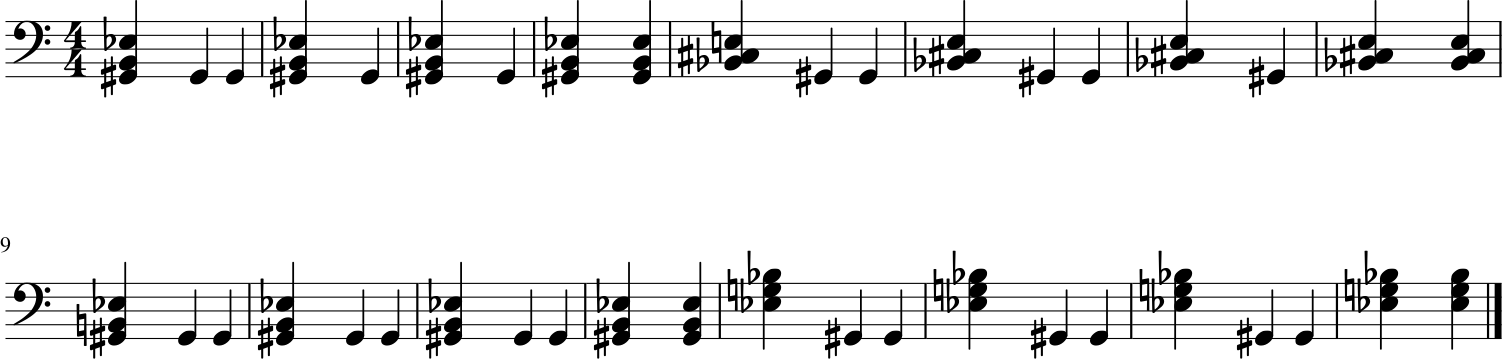

In [18]:
npenc2stream(data.train_ds.x[10]).show()